# CS 584 Assignment 1 -- Text Classification (Machine Learning and NLP Basics)

#### Name: Archana Kalburgi
#### Stevens ID: 10469491

## Part B: Multi-class Classification (20 Points)

## In this assignment, you are required to follow the steps below:
1. Review the lecture slides.
2. Implement the data loading, preprocessing, tokenization, and TF-IDF feature extraction.
3. Implement Logistic Regression model, evaluation metrics, SGD, and Mini-batch GD.
4. Implement Cross-validation to choose the best lambda.
5. Analysis the results in the Conlusion part.

**Before you start**
- Please read the code very carefully.
- Install these packages (jupyterlab, nltk, numpy, and matplotlib) using the following command.
```console
pip install -r requirements.txt
```
- You are **NOT** allowed to use other packages unless otherwise specified.
- You are **ONLY** allowed to edit the code between `# Start your code here` and `# End` for each block.
- Most of the code can be reused from the Assignment 1.1.

## 1. Data Processing

* Download the dataset from Canvas
* Load data to text and labels
* Preprocessing
* Tokenization
* Split data
* Feature extraction (TF-IDF)

#### Download NLTK stopwords

In [45]:
import os

import nltk


nltk_path = os.path.join('a1-data', 'nltk')
nltk.download('stopwords', download_dir=nltk_path)
nltk.data.path.append(nltk_path)

[nltk_data] Downloading package stopwords to a1-data/nltk...
[nltk_data]   Package stopwords is already up-to-date!


In [46]:
import sys
import math
import string

def print_line(*args):
    """ Inline print and go to the begining of line
    """
    args1 = [str(arg) for arg in args]
    str_ = ' '.join(args1)
    sys.stdout.write(str_ + '\r')
    sys.stdout.flush()

In [47]:
from typing import List, Tuple, Union

import numpy as np

### 1.1 Load data

- Load sentences and labels
- Transform string labels into integers

In [48]:
def load_sentence_label(data_path: str) -> Tuple[List[str], List[str]]:
    """ Load sentences and labels from the specified path
    Args:
        data_path: data_path: path to the data file, e.g., 'a1-data/SMSSpamCollection'
        sentences: the raw text list of all sentences
    Returns:
        labels: the label list of all sentences
    """
    sentences, labels = [], []
    # Start your code here (load text and label from files)
    
    with open("data/books.txt") as f:
        lines = f.readlines()
        
    mapper = map(lambda x: x.split("\t"), lines)
    
    for item in mapper:
        labels.append(item[0])
        sentences.append(item[1])
    
    # End
    return sentences, labels


In [49]:
data_path = os.path.join('a1-data', 'books.txt')
sentences, labels = load_sentence_label(data_path)

label_map = {}
for label in sorted(list(set(labels))):
    label_map[label] = len(label_map)
labels = np.array([label_map[label] for label in labels], dtype=int)
sentences = np.array(sentences, dtype=object)

print('Label map:', label_map)
print('Number of sentences and labels:', len(sentences), len(labels))


Label map: {'Arthur Conan Doyle': 0, 'Fyodor Dostoyevsky': 1, 'Jane Austen': 2}
Number of sentences and labels: 19536 19536


#### Split the data into training, validation and test

In [50]:
def train_test_split(sentences: np.ndarray,
                     labels: np.ndarray,
                     test_ratio: float = 0.2) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """ Split the sentences and labels into training and test data by shuffling
    Args:
        sentences: A numpy array containing all sentences
        labels: A number array containing label ids
        test_ratio: A float number to calculate the number of test data

    Returns:
        train_sentences: A numpy array containing all training sentences
        train_labels: A number array containing all training label ids
        test_sentences: A numpy array containing all test sentences
        test_labels: A number array containing all test label ids
    """
    assert 0 < test_ratio < 1
    assert len(sentences) == len(labels)

    train_index, test_index = [], []
    
    # Start your code here (split the index for training and test)
    
    end = math.ceil((1-test_ratio)*len(labels))
    train_index = [i for i in range(end)]
    test_index = [i for i in range(len(labels)-end)]
    np.random.shuffle(train_index)
    np.random.shuffle(train_index)
    
    # End

    train_sentences, train_labels = sentences[train_index], labels[train_index]
    test_sentences, test_labels = sentences[test_index], labels[test_index]
    return train_sentences, train_labels, test_sentences, test_labels


In [51]:
np.random.seed(6666)

test_ratio = 0.2
valid_ratio = 0.1
(train_sentences, train_labels,
    test_sentences, test_labels) = train_test_split(sentences, labels, test_ratio)
(train_sentences, train_labels,
    valid_sentences, valid_labels) = train_test_split(train_sentences, train_labels, valid_ratio)

print('Training data length:', len(train_sentences))
print('Validation data length:', len(valid_sentences))
print('Test data length:', len(test_sentences))


Training data length: 14067
Validation data length: 1562
Test data length: 3907


In [52]:
def count_label(labels: np.ndarray, label_map: dict[str, int]) -> dict[str, int]:
    """
    Args:
        labels: The labels of a dataset 
        label_map: The mapping from label to label id
    Returns:
        label_count: The mapping from label to its count
    """
    label_count = {key: 0 for key in label_map.keys()}
    # Start your code here (count the number of each label)
    arthur_conan_doyle = len(list(filter(lambda x : x==0, labels)))
    fyodor_dostoyevsky = len(list(filter(lambda x : x==1, labels)))
    jane_austen = len(list(filter(lambda x : x==2, labels)))
    label_count['Arthur Conan Doyle']=arthur_conan_doyle
    label_count['Fyodor Dostoyevsky']=fyodor_dostoyevsky
    label_count['Jane Austen']=jane_austen
    
    # End
    return label_count

In [54]:
print('Training:', count_label(train_labels, label_map))
print('Validation:', count_label(valid_labels, label_map))
print('Test:', count_label(test_labels, label_map))


Training: {'Arthur Conan Doyle': 2281, 'Fyodor Dostoyevsky': 1846, 'Jane Austen': 9940}
Validation: {'Arthur Conan Doyle': 262, 'Fyodor Dostoyevsky': 198, 'Jane Austen': 1102}
Test: {'Arthur Conan Doyle': 0, 'Fyodor Dostoyevsky': 0, 'Jane Austen': 3907}


#### Dataset statistics
Fill this table with the statistics you just printed (double click this cell to edit)

|                | Arthur Conan Doyle | Fyodor Dostoyevsky | Jane Austen | Total  |
|:--------------:|--------------------|--------------------|-------------|--------|
|  **Training**  |       2281         |       1846         |    9940     | 14,067 |
| **Validation** |        262         |        198         |    1102     |  1562  |
|    **Test**    |        0           |         0          |    3907     |  3907  |
|    **Total**   |       2543         |       2044         |   14,967    |        |

### 1.2 Preprocess
In this section, you need to remove all the unrelated characters, including punctuation, urls, and numbers. Please fill up the functions and test them by running the following cell.

In [55]:
import re


class Preprocessor:
    def __init__(self, punctuation=True, url=True, number=True):
        self.punctuation = punctuation
        self.url = url
        self.number = number

    def apply(self, sentence: str) -> str:
        """ Apply the preprocessing rules to the sentence
        Args:
            sentence: raw sentence
        Returns:
            sentence: clean sentence
        """
        sentence = sentence.lower()
        if self.url:
            sentence = Preprocessor.remove_url(sentence)
        if self.punctuation:
            sentence = Preprocessor.remove_punctuation(sentence)
        if self.number:
            sentence = Preprocessor.remove_number(sentence)
        sentence = re.sub(r'\s+', ' ', sentence)
        return sentence

    @staticmethod
    def remove_punctuation(sentence: str) -> str:
        """ Remove punctuations in sentence with re
        Args:
            sentence: sentence with possible punctuations
        Returns:
            sentence: sentence without punctuations
        """
        # Start your code here
        sentence = sentence.translate(str.maketrans('','', string.punctuation))   

        # End
        return sentence

    @staticmethod
    def remove_url(sentence: str) -> str:
        """ Remove urls in text with re
        Args:
            sentence: sentence with possible urls
        Returns:
            sentence: sentence without urls
        """
        # Start your code here
        pattern = re.compile("(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})")
        sentence = pattern.sub('', sentence)
        
        # End
        return sentence

    @staticmethod
    def remove_number(sentence: str) -> str:
        """ Remove numbers in sentence with re
        Args:
            sentence: sentence with possible numbers
        Returns:
            sentence: sentence without numbers
        """
        # Start your code here
        sentence = sentence.translate(str.maketrans('','',string.digits))
        # End
        return sentence
    

##### Test your implementation by running the following cell.

In [56]:
sentence = "Interest rates are trimmed to 7.5 by the South African central bank (https://www.xxx.xxx), but the lack of warning hits the rand and surprises markets."

processor = Preprocessor()
clean_sentence = processor.apply(sentence)

print(f'"{sentence}"') 
print('===>')
print(f'"{clean_sentence}"')


"Interest rates are trimmed to 7.5 by the South African central bank (https://www.xxx.xxx), but the lack of warning hits the rand and surprises markets."
===>
"interest rates are trimmed to by the south african central bank but the lack of warning hits the rand and surprises markets"


### 1.3 Tokenization

In [57]:
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jovyan/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [58]:
from nltk.tokenize import word_tokenize
from nltk import PorterStemmer
from nltk.corpus import stopwords


stopwords_set = set(stopwords.words('english'))
stemmer = PorterStemmer()
print(list(stopwords_set)[:10])

['shan', 'through', 'them', 'about', 'with', 'again', 'then', 'when', 'will', "aren't"]


In [59]:
def tokenize(sentence: str) -> List[str]:
    """ Tokenize a sentence into tokens (words)
    Args:
        sentence: clean sentence
    Returns:
        tokens
    """
    words = []
    # Start your code here
    #     Step 1. Split sentence into words
    #     Step 2. Extract word stem using the defined stemmer (PorterStemmer) by calling stemmer.stem(word)
    #     Step 3. Remove stop words using the defined stopwords_set
    
    tokens = nltk.tokenize.word_tokenize(sentence)
    stopwords = nltk.corpus.stopwords.words('english')
    tokens = [token for token in tokens if token not in stopwords]
    lemmatizer = nltk.stem.WordNetLemmatizer()
    words = [lemmatizer.lemmatize(token) for token in tokens]
    
    # End
    return words


##### Test your implementation by running the following block.

In [60]:
sentence = "Interest rates are trimmed to 7.5 by the South African central bank (https://www.xxx.xxx), but the lack of warning hits the rand and surprises markets."

processor = Preprocessor()
clean_sentence = processor.apply(sentence)
tokens = tokenize(clean_sentence)

print(f'"{sentence}"') 
print('===>')
print(f'"{tokens}"')


"Interest rates are trimmed to 7.5 by the South African central bank (https://www.xxx.xxx), but the lack of warning hits the rand and surprises markets."
===>
"['interest', 'rate', 'trimmed', 'south', 'african', 'central', 'bank', 'lack', 'warning', 'hit', 'rand', 'surprise', 'market']"


### 1.5 Feature Extraction

TF-IDF:
$$\text{TF-IDF}(t, d) = \frac{f_{t, d}}{\sum_{t'}{f_{t', d}}} \times \log{\frac{N}{n_t}}$$

- $t$: A term
- $d$: A document. Here, we regard a sentence as a document
- $f_{t, d}$: Number of term $t$ in $d$
- $N$: Number of document
- $n_t$: Number of document containing $t$

In [61]:
from collections import defaultdict
from collections import defaultdict, Counter

class TfIdfEncoder:
    def __init__(self):
        self.vocab = defaultdict(int)
        self.token2index = {}
        self.df = defaultdict(int)
        self.num_doc = 0
        self.processor = Preprocessor()

    def fit(self, sentences: Union[List[str], np.ndarray]) -> int:
        """ Using the given texts to store key information in TF-IDF calculation
            In this function, you are required to implement the fitting process.
                1. Construct the vocabulary and store the frequency of tokens (self.vocab).
                2. Construct the document frequency map to tokens (self.df).
                3. Construct the token to index map based on the frequency.
                   The token with a higher frequency has the smaller index
        Args:
            sentences: Raw sentences
        Returns:
            token_num
        """
        self.num_doc = len(sentences)
        for i, sentence in enumerate(sentences):
            if i % 100 == 0 or i == len(sentences) - 1:
                print_line('Fitting TF-IDF encoder:', (i + 1), '/', len(sentences))
            # Start your code here (step 1 & 2)
            
            clean_sentences = self.processor.apply(sentence)
            tokens = tokenize(clean_sentences)
            
            token_counter = Counter(tokens)
            for i,j in token_counter.items():
                self.vocab[i] += j
                self.df[i] += 1
                
            # End
        print_line('\n')
        
        # Start your code here (Step 3)
        self.vocab = {i:j for i,j in sorted(self.vocab.items(), key=lambda x:x[1], reverse=True)}
        self.vocab = {key: self.vocab[key] for key in list(self.vocab.keys())}
        self.token2index = {key: idx for idx, key in enumerate(self.vocab.keys())}
        
        # End
        token_num = len(self.token2index) 
        print('The number of distinct tokens:', token_num)
        return token_num

    def encode(self, sentences: Union[List[str], np.ndarray]) -> np.ndarray:
        """ Encode the sentences into TF-IDF feature vector
            Note: if a token in a sentence does not exist in the fit encoder, we just ignore it.
        Args:
            sentences: Raw sentences
        Returns:
            features: A (n x token_num) matrix, where n is the number of sentences
        """
        n = len(sentences)
        features = np.zeros((n, len(self.token2index)))
        for i, sentence in enumerate(sentences):
            if i % 100 == 0 or i == n - 1:
                print_line('Encoding with TF-IDF encoder:', (i + 1), '/', n)
            
            # Start your code (calculate TF-IDF)
            clean_sentence = self.processor.apply(sentence)
            tokens = tokenize(clean_sentence)
            
            tokens_counter = Counter(tokens)
            
            for token, counter in tokens_counter.items():
                if token in self.vocab:
                    features[i][self.token2index[token]] = counter/min(len(tokens),len(self.vocab))

        idf_values = np.zeros(len(self.vocab))

        for i,j in self.df.items():
            if i in self.vocab:
                idf_values[self.token2index[i]] = np.log((self.num_doc + 1)/(j + 1))+1
                
        features = features*idf_values[None:,]
            
            # End
        print_line('\n')
        return features
    

##### Test your implementation by running the following cell.

In [62]:
encoder = TfIdfEncoder()
encoder.fit(train_sentences[:100])
features = encoder.encode(train_sentences[:10])

print(features[:5])

Fitting TF-IDF encoder: 100 / 100
The number of distinct tokens: 1693
Encoding with TF-IDF encoder: 10 / 10
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.22542057 0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.04526579 ... 0.         0.         0.        ]]


#### Encode training, validation, and test dataset

In [63]:
num_class = 3

encoder = TfIdfEncoder()
vocab_size = encoder.fit(train_sentences)

x_train = encoder.encode(train_sentences)
x_valid = encoder.encode(valid_sentences)
x_test = encoder.encode(test_sentences)

y_train = np.zeros((len(train_labels), num_class))
y_valid = np.zeros((len(valid_labels), num_class))
y_test = np.zeros((len(test_labels), num_class))
y_train[np.arange(len(train_labels)), train_labels] = 1
y_valid[np.arange(len(valid_labels)), valid_labels] = 1
y_test[np.arange(len(test_labels)), test_labels] = 1

print('The size of training set:', x_train.shape, y_train.shape)
print('The size of validation set:', x_valid.shape, y_valid.shape)
print('The size of test set:', x_test.shape, y_test.shape)

Fitting TF-IDF encoder: 14067 / 14067
The number of distinct tokens: 22135
Encoding with TF-IDF encoder: 14067 / 14067
Encoding with TF-IDF encoder: 1562 / 1562
Encoding with TF-IDF encoder: 3907 / 3907
The size of training set: (14067, 22135) (14067, 3)
The size of validation set: (1562, 22135) (1562, 3)
The size of test set: (3907, 22135) (3907, 3)


## 2. Logistic Regression
In this section, you are required to implement a Logistic Regression (LR) model with $L_2$ regularization from scratch. 

The objective function of LR for binary classification:

$$J = L(\mathbf{x}, \mathbf{y} \mid \mathbf{w}, \mathbf{b}) = -\frac{1}{n}\sum_{i=1}^{N}\sum_{k=1}^{K}y_{ik}log\frac{e^{f_k}}{\sum_{c=1}^{K}e^{f_c}} + \lambda \sum_{j=1}^{d}w_{kj}^2$$

- $\hat{\mathbf{y}} = \text{Softmax}(\mathbf{x}\mathbf{w} + \mathbf{b})$
- $n$: Number of samples
- $d$: Dimension of $\mathbf{w}$

### 2.1 Logistic Regression Model

In [64]:
def softmax(x: np.ndarray, axis: int = -1) -> np.ndarray:
    """ The softmax activation function
    Args:
        x: Input matrix or vector
        axis: The dimension of x that needs to run softmax, default -1, i.e., the last dimension
    Returns:
        output: Softmax value of the specified dimension in x
    """
    # Start your code here
    x = np.exp(x)/np.sum(np.exp(x), axis=1, keepdims=True)
    # End
    
    return x


In [94]:
class LogisticRegression:
    def __init__(self, feature_dim: int, num_class: int, lambda_: float):
        """ Logistic Regression Model
        Args:
            feature_dim: feature dimension
            num_class: number of class
            lambda_: lambda in L2 regularizer
        """
        # Start your code here (initialize weight and bias)
        self.w = np.random.rand(num_class, feature_dim)
        self.b = np.random.rand(num_class)
        # End
        
        self.lambda_ = lambda_
        self.eps = 1e-9

    def forward(self, x: np.ndarray) -> np.ndarray:
        """ Forward process of logistic regression
            Calculate y_hat using x
        Args:
            x: Input data
        Returns:
            y_hat: Output
        """
        y_hat = 0
        
        # Start your code here (calculate y_hat of logistic regression using x)
        y_hat = softmax(np.matmul(x, self.w.T)+self.b).squeeze()
        # End
        
        return y_hat

    def backward(self,
                 x: np.ndarray,
                 y_hat: np.ndarray,
                 y: np.ndarray) -> Tuple[np.ndarray, Union[float, np.ndarray]]:
        """ Backward process of logistic regression
            Calculate the gradient of w and b
        Args:
            x: Input data
            y_hat: Output of forward
            y: Ground-truth
        Returns:
            w_grad: Gradient of w
            b_grad: Gradient of b
        """
        w_grad, b_grad = 0.0, 0.0
        n = len(x)
        
        # Start your code here (calculate the gradient of w and b)
        w_grad = (1/n)*np.matmul((y_hat-y).T,x) + 2*self.lambda_*self.w
        b_grad = (1/n)*np.sum((y_hat-y),axis=0)
        # End
        
        return w_grad, b_grad

    def categorical_cross_entropy_loss(self,
                                       y_hat: np.ndarray,
                                       y: np.ndarray) -> Union[float, np.ndarray]:
        """ Calculate the binary cross-entropy loss
        Args:
            y_hat: Output of forward
            y: Ground-truth
        Returns:
            loss: BCE loss
        """
        y_hat = np.clip(y_hat, a_min=self.eps, a_max=1 - self.eps)
        loss = 0
        
        # Start your code here (Calculate the binary cross-entropy)
        n = y.shape[0]
        loss = (-1/n)*np.sum(y*np.log(y_hat)) + self.lambda_*np.sum(self.w**2)
        # End
        
        return loss

    def gradient_descent(self, w_grad: np.ndarray, b_grad: Union[np.ndarray, float], lr: float):
        self.w -= lr * w_grad
        self.b -= lr * b_grad

    def predict(self, y_hat: np.ndarray) -> np.ndarray:
        """ Predict the label using the output y_hat
        Args:
            y_hat: Model output
        Returns:
            pred: Prediction
        """
        pred = np.zeros_like(y_hat)
        index = np.argmax(y_hat, axis=-1)
        pred[np.arange(len(y_hat)), index] = 1
        return pred
    

### 2.2 Evaluation Metrics

Accuracy, Precision, Recall, F1

In [72]:
import sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support


def get_metrics(y_pred: np.ndarray, y_true: np.ndarray) -> Tuple[float, np.ndarray, np.ndarray, np.ndarray]:
    """ Calculate the accuracy, precision, recall, and f1 score.
        You are allowed to use precision_recall_fscore_support from scikit-learn. Please set average to 'micro'
    Args:
        y_pred: Prediction
        y_true: Ground-truth
    Returns:
        accuracy: float number. The accuracy for the whole dataset
        precision, recall, f1: np.ndarray (num_class, ). The precision, recall, f1 for each class
    """
    assert y_pred.shape == y_true.shape
    accuracy, precision, recall, f1 = 0.0, 0.0, 0.0, 0.0
    
    # Start your code here
    y_pred=np.argmax(y_pred, axis=1)
    y_true=np.argmax(y_true, axis=1)
    accuracy = sklearn.metrics.accuracy_score(y_true, y_pred)
    precision, recall, f1, support = sklearn.metrics.precision_recall_fscore_support(y_true, y_pred, average='micro')
    # End
    
    return accuracy, precision, recall, f1

### 2.3 Stochastic Gradient Descent (SGD)

In [73]:
from collections import OrderedDict


def train_sgd(model: 'LogisticRegression',
              x_train: np.ndarray,
              y_train: np.ndarray,
              x_valid: np.ndarray,
              y_valid: np.ndarray,
              lr: float,
              num_epoch: int,
              print_every: int = 10) -> Tuple[dict[str, List], dict[str, List]]:
    """ Training with Stochastic Gradient Descent
    Args:
        model: The logistic regression model
        x_train: Training feature, (n x d) matrix
        y_train: Training label, (n, ) vector
        x_valid: Validation feature, (n x d) matrix
        y_valid: Validation label, (n, ) vector
        lr: Learning rate
        num_epoch: Number of training epochs
        print_every: Print log every {print_every} epochs
    Returns:
        train_history: Log of training information. The format of training history is
                       { 'loss': [] }
                       It records the average loss of each epoch.
        valid_history: Log of validation information. The format of validation history is
                       {
                           'loss': [],
                           'accuracy': [],
                           'precision': [],
                           'recall': [],
                           'f1': []
                       }
    """
    train_history = OrderedDict({'loss': []})
    valid_history = OrderedDict({
        'loss': [],
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': []
    })

    def format_output(epoch, num_epoch, train_history, valid_history):
        epoch_log = f'Epoch {epoch + 1} / {num_epoch}'
        train_log = ' - '.join([f'train_{key}: {val[-1]:.4f}' for key, val in train_history.items()])
        valid_log = ' - '.join([f'valid_{key}: {val[-1]:.4f}' for key, val in valid_history.items()])
        log = f'{epoch_log}: {train_log} - {valid_log}'
        return log

    train_num_samples = len(x_train)
    for epoch in range(num_epoch):
        epoch_loss = 0.0
        # Start your code here (training)
        #     Step 1. Model forward
        #     Step 2. Calculate loss
        #     Step 3. Model backward
        #     Step 4. Optimization with gradient descent
        
        for i in range(train_num_samples):
            y_hat = model.forward(x_train[i].reshape(1,-1))
            epoch_loss += model.categorical_cross_entropy_loss(y_hat, y_train[i].reshape(1,-1))
            w_grad, b_grad = model.backward(x_train[i].reshape(1,-1), y_hat, y_train[i].reshape(1,-1))
            model.gradient_descent(w_grad, b_grad, lr)
        # End

        valid_loss = 0.
        accuracy, precision, recall, f1 = 0.0, 0.0, 0.0, 0.0
        # Start your code here (validation)
        #     Step 1. Predict
        #     Step 2. Calculate loss
        #     Step 3. Calculate metrics
        y_hat_valid = model.forward(x_valid)
        valid_loss = model.categorical_cross_entropy_loss(y_hat_valid, y_valid)
        accuracy, precision, recall, f1 = get_metrics(y_hat_valid, y_valid)
        # End

        train_history['loss'].append(epoch_loss / train_num_samples)
        
        for vals, val in zip(valid_history.values(), [valid_loss, accuracy, precision, recall, f1]):
            vals.append(val)
        log = format_output(epoch, num_epoch, train_history, valid_history)
        if epoch % print_every == 0 or epoch == num_epoch - 1:
            print(log)
        else:
            print_line(log)

    return train_history, valid_history 

Run SGD

In [74]:
np.random.seed(6666)

num_epoch = 100
lr = 1e-1
lambda_ = 1e-7
print_every = 10

model_sgd = LogisticRegression(feature_dim=vocab_size, num_class=num_class, lambda_=lambda_)
sgd_train_history, sgd_valid_history = train_sgd(model_sgd, x_train, y_train, x_valid, y_valid, lr, num_epoch, print_every)


Epoch 1 / 100: train_loss: 0.4511 - valid_loss: 0.2857 - valid_accuracy: 0.9245 - valid_precision: 0.9245 - valid_recall: 0.9245 - valid_f1: 0.9245
Epoch 11 / 100: train_loss: 0.0908 - valid_loss: 0.1028 - valid_accuracy: 0.9725 - valid_precision: 0.9725 - valid_recall: 0.9725 - valid_f1: 0.9725
Epoch 21 / 100: train_loss: 0.0667 - valid_loss: 0.0790 - valid_accuracy: 0.9789 - valid_precision: 0.9789 - valid_recall: 0.9789 - valid_f1: 0.9789
Epoch 31 / 100: train_loss: 0.0564 - valid_loss: 0.0679 - valid_accuracy: 0.9795 - valid_precision: 0.9795 - valid_recall: 0.9795 - valid_f1: 0.9795
Epoch 41 / 100: train_loss: 0.0505 - valid_loss: 0.0614 - valid_accuracy: 0.9814 - valid_precision: 0.9814 - valid_recall: 0.9814 - valid_f1: 0.9814
Epoch 51 / 100: train_loss: 0.0468 - valid_loss: 0.0571 - valid_accuracy: 0.9827 - valid_precision: 0.9827 - valid_recall: 0.9827 - valid_f1: 0.9827
Epoch 61 / 100: train_loss: 0.0441 - valid_loss: 0.0541 - valid_accuracy: 0.9834 - valid_precision: 0.9834 

### 2.4 Mini-batch Gradient Descent

In [75]:
def train_mbgd(model: 'LogisticRegression',
               x_train: np.ndarray,
               y_train: np.ndarray,
               x_valid: np.ndarray,
               y_valid: np.ndarray,
               lr: float,
               num_epoch: int,
               batch_size: int,
               print_every: int = 10) -> Tuple[dict[str, List], dict[str, List]]:
    """ Training with Stochastic Gradient Descent
    Args:
        model: The logistic regression model
        x_train: Training feature, (n x d) matrix
        y_train: Training label, (n, ) vector
        x_valid: Validation feature, (n x d) matrix
        y_valid: Validation label, (n, ) vector
        lr: Learning rate
        num_epoch: Number of training epochs
        batch_size: Number of training samples in a batch
        print_every: Print log every {print_every} epochs
    Returns:
        train_history: Log of training information. The format of training history is
                       { 'loss': [] }
                       It records the average loss of each epoch.
        valid_history: Log of validation information. The format of training and validation history is
                       {
                           'loss': [],
                           'accuracy': [],
                           'precision': [],
                           'recall': [],
                           'f1': []
                       }
    """
    train_history = OrderedDict({'loss': []})
    valid_history = OrderedDict({
        'loss': [],
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': []
    })

    def format_output(epoch, num_epoch, train_history, valid_history):
        epoch_log = f'Epoch {epoch + 1} / {num_epoch}'
        train_log = ' - '.join([f'train_{key}: {val[-1]:.4f}' for key, val in train_history.items()])
        valid_log = ' - '.join([f'valid_{key}: {val[-1]:.4f}' for key, val in valid_history.items()])
        log = f'{epoch_log}: {train_log} - {valid_log}'
        return log

    train_num_samples = len(x_train)
    n_batch = train_num_samples // batch_size
    for epoch in range(num_epoch):
        epoch_loss = 0.0
        # Start your code here (training)
        #     Step 1. Model forward
        #     Step 2. Calculate loss
        #     Step 3. Model backward
        #     Step 4. Optimization with gradient descent
        
        for i in range(n_batch):
            y_hat = model.forward(x_train[i*batch_size:(i+1)*batch_size])
            epoch_loss += model.categorical_cross_entropy_loss(y_hat, y_train[i*batch_size:(i+1)*batch_size])
            w_grad, b_grad = model.backward(x_train[i*batch_size:(i+1)*batch_size], y_hat, y_train[i*batch_size:(i+1)*batch_size])
            model.gradient_descent(w_grad, b_grad, lr)
        # End

        valid_loss = 0.
        accuracy, precision, recall, f1 = 0.0, 0.0, 0.0, 0.0
        # Start your code here (validation)
        #     Step 1. Predict
        #     Step 2. Calculate loss
        #     Step 3. Calculate metrics
        y_hat_valid = model.forward(x_valid)
        valid_loss = model.categorical_cross_entropy_loss(y_hat_valid, y_valid)
        accuracy, precision, recall, f1 = get_metrics(y_hat_valid, y_valid)
        # End

        train_history['loss'].append(epoch_loss / train_num_samples)
        for vals, val in zip(valid_history.values(), [valid_loss, accuracy, precision, recall, f1]):
            vals.append(val)
        log = format_output(epoch, num_epoch, train_history, valid_history)
        if epoch % print_every == 0 or epoch == num_epoch - 1:
            print(log)
        else:
            print_line(log)

    return train_history, valid_history


Run Mini-batch Gradient Descent

In [76]:
np.random.seed(6666)

num_epoch = 100
lr = 1e-1
batch_size = 4
lambda_ = 1e-7
print_every = 10

model_mbgd = LogisticRegression(feature_dim=vocab_size, num_class=num_class, lambda_=lambda_)
mbgd_train_history, mbgd_valid_history = train_mbgd(model_mbgd, x_train, y_train, x_valid, y_valid, lr, num_epoch, batch_size, print_every)


Epoch 1 / 100: train_loss: 0.1495 - valid_loss: 0.4535 - valid_accuracy: 0.8291 - valid_precision: 0.8291 - valid_recall: 0.8291 - valid_f1: 0.8291
Epoch 11 / 100: train_loss: 0.0415 - valid_loss: 0.1785 - valid_accuracy: 0.9456 - valid_precision: 0.9456 - valid_recall: 0.9456 - valid_f1: 0.9456
Epoch 21 / 100: train_loss: 0.0296 - valid_loss: 0.1337 - valid_accuracy: 0.9616 - valid_precision: 0.9616 - valid_recall: 0.9616 - valid_f1: 0.9616
Epoch 31 / 100: train_loss: 0.0242 - valid_loss: 0.1123 - valid_accuracy: 0.9680 - valid_precision: 0.9680 - valid_recall: 0.9680 - valid_f1: 0.9680
Epoch 41 / 100: train_loss: 0.0209 - valid_loss: 0.0990 - valid_accuracy: 0.9699 - valid_precision: 0.9699 - valid_recall: 0.9699 - valid_f1: 0.9699
Epoch 51 / 100: train_loss: 0.0187 - valid_loss: 0.0896 - valid_accuracy: 0.9731 - valid_precision: 0.9731 - valid_recall: 0.9731 - valid_f1: 0.9731
Epoch 61 / 100: train_loss: 0.0170 - valid_loss: 0.0825 - valid_accuracy: 0.9738 - valid_precision: 0.9738 

### 2.5 Evaluation
You are required to report the loss, accuracy, precision, recall, and f1 on test set and plot the the curve of them for both SGD and Mini-batch GD on train and validation set

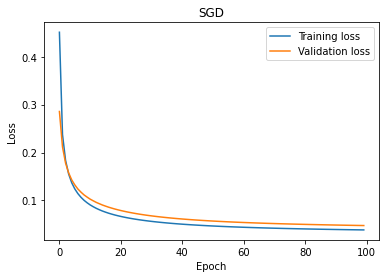

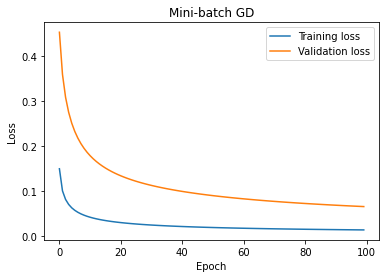

In [77]:
# Start your code here
# Calculate the metrics for test set and fill in the table below

# SGD
y_hat_sgd = model_sgd.predict(y_test)
accuracy_sgd, precision_sgd, recall_sgd, f1_sgd=get_metrics(y_hat_sgd, y_test)

import matplotlib.pyplot as plt

%matplotlib inline

# sgd_train_history, sgd_valid_history
plt.plot(range(num_epoch), sgd_train_history['loss'], sgd_valid_history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(["Training loss", "Validation loss"])
plt.title('SGD')
plt.show()

# Mini-batch GD
y_hat_mbgd = model_mbgd.predict(y_test)
accuracy_mbgd, precision_mbgd, recall_mbgd, f1_mbgd=get_metrics(y_hat_mbgd, y_test)

plt.plot(range(num_epoch), mbgd_train_history['loss'], mbgd_valid_history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(["Training loss", "Validation loss"])
plt.title('Mini-batch GD')
plt.show()

# End

#### Evaluation Metrics on Test set
Fill this table with the result you just printed (double click this cell to edit)

|     Optimizer     | Accuracy    | Precision   | Recall      | F1 Score    |
|:-----------------:|-------------|-------------|-------------|-------------|
|      **SGD**      |     0.9840  |  0.9840     |  0.9840     |  0.9840     |
| **Mini-batch GD** |     0.9795  |  0.9795     |  0.9795     |  0.9795     |


##### Please run the following cell to plot the training loss curve for SGD and Mini-batch GD

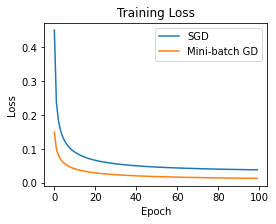

In [78]:
import matplotlib.pyplot as plt

%matplotlib inline

fig = plt.figure(figsize=(4, 3))
plt.plot(sgd_train_history['loss'], label='SGD')
plt.plot(mbgd_train_history['loss'], label='Mini-batch GD')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss')
plt.show()

##### Please run the following cell to plot the validation metrics curve for SGD and Mini-batch GD

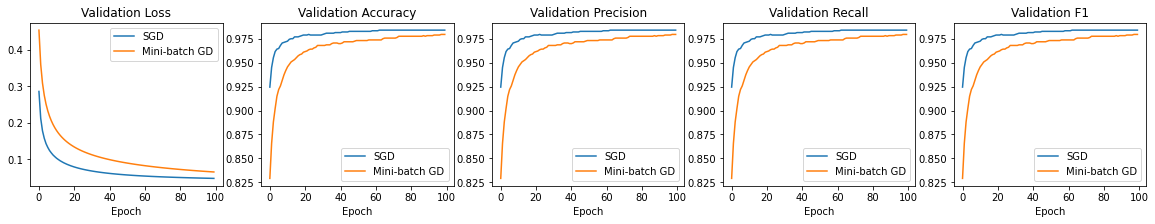

In [79]:
fig, axes = plt.subplots(1, 5, figsize=(20, 3))
for i, key in enumerate(sgd_valid_history.keys()):
    sgd_vals, mbgd_vals = sgd_valid_history[key], mbgd_valid_history[key]
    ax = axes[i]
    ax.plot(sgd_vals, label='SGD')
    ax.plot(mbgd_vals, label='Mini-batch GD')
    ax.legend()
    ax.set_xlabel('Epoch')
    ax.set_title('Validation ' + key.capitalize())
plt.show()


## 3. Cross-Validation

You are required to use cross-validation to choose the best $\lambda$ with Mini-batch GD.

The best $\lambda$ should be chosen by monitoring validation $F_1$ score.

In [80]:
lambdas = [1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 0.0]

In [92]:
best_lambda = 0.0
best_f1 = 0.0

num_epoch = 100
lr = 1e-1
batch_size = 4
print_every = 100

# Start your code here
#     Step 1. Iterate all lambdas
#     Step 2. set the random seed and run train_mbgd for every lambda
#     Step 3. Choose the best lambda

k = 5
num_class = 3

mini_batch_losses = []
lambda_loss_map = dict()

x_train_batches = np.array_split(x_train, x_train.shape[0] // k)
y_train_batches = np.array_split(y_train, x_train.shape[0] // k)

for lam in lambdas:
    np.random.seed(6666)
    
    model_mbgd_lr = LogisticRegression(feature_dim=vocab_size, num_class=num_class, lambda_=lam)
    mini_batch_loss = 0
    
    print("\n")
    print(lam)
    
    for i in range(k):
        xk_val = x_train_batches[i]
        yk_val = y_train_batches[i]
        
        xk_train = np.vstack((x_train_batches[:i]+x_train_batches[i+1:]))
        yk_train = np.vstack((y_train_batches[:i]+y_train_batches[i+1:]))
        
        mbgd_train_history, mbgd_valid_history=\
        train_mbgd(model_mbgd_lr, xk_train, yk_train, xk_val, yk_val, lr, num_epoch, batch_size, print_every)

        mini_batch_loss += mbgd_valid_history['loss'][-1]
    
    mini_batch_loss /= k
    
    mini_batch_losses.append(mini_batch_loss)
    
    lambda_loss_map[lam] = mini_batch_loss
    
best_lambda=min(lambda_loss_map, key=lambda_loss_map.get)
    
# End
print("\n")
print(best_lambda)




1
Epoch 1 / 100: train_loss: 4.5784 - valid_loss: 0.8411 - valid_accuracy: 0.6667 - valid_precision: 0.6667 - valid_recall: 0.6667 - valid_f1: 0.6667
Epoch 100 / 100: train_loss: 0.2066 - valid_loss: 0.8411 - valid_accuracy: 0.6667 - valid_precision: 0.6667 - valid_recall: 0.6667 - valid_f1: 0.6667
Epoch 1 / 100: train_loss: 0.2066 - valid_loss: 0.9224 - valid_accuracy: 0.6667 - valid_precision: 0.6667 - valid_recall: 0.6667 - valid_f1: 0.6667
Epoch 100 / 100: train_loss: 0.2066 - valid_loss: 0.9224 - valid_accuracy: 0.6667 - valid_precision: 0.6667 - valid_recall: 0.6667 - valid_f1: 0.6667
Epoch 1 / 100: train_loss: 0.2066 - valid_loss: 0.6570 - valid_accuracy: 0.8000 - valid_precision: 0.8000 - valid_recall: 0.8000 - valid_f1: 0.8000
Epoch 100 / 100: train_loss: 0.2066 - valid_loss: 0.6570 - valid_accuracy: 0.8000 - valid_precision: 0.8000 - valid_recall: 0.8000 - valid_f1: 0.8000
Epoch 1 / 100: train_loss: 0.2066 - valid_loss: 0.9768 - valid_accuracy: 0.6000 - valid_precision: 0.6

#### Report the best $\lambda$ value.

Answer:  **1e-07**

# 4. Conclusion

Provide an analysis for all the results

**Answer**

Some of the key observations made while solving this exercise is that with SDG we can approach optimum _w_ and _b_ within less number of iterations compared to Mini batch gradient descent, this can also be verified from the above graph.\
    SDG takes longer time compared to Mini batch to train the model. This is because it had to update the _w_ and _b_ parameters for every single observation, compared to mini batch where parameters are updated for each batches.\
    With K-cross validation it can be seen that the best lambda value is : **1e-07**\
Since we are suppposed to select a lambda that has lowest loss, In this case, the loss function decreases fast when the learning rate is 1e-07